In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_result
from analyze_tools import plot_tools as pt
import analyze_tools.monte_carlo as at

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative


In [2]:
s = red.sigma_Ar_Xe
e = red.epsilon_Ar_Xe

re = s * 2 ** (1/6)
k = 4 * e * (156 * (s**12 / re**14) - 42 * (s**6 / re**8))
mu = red.mass_dict['Ar'] * red.mass_dict['Xe'] / (red.mass_dict['Ar'] + red.mass_dict['Xe'])
omega = np.sqrt(k / mu)

vib_freq = omega / (2 * np.pi * red.c * red.sigma)
vib_freq

22.766978335022763

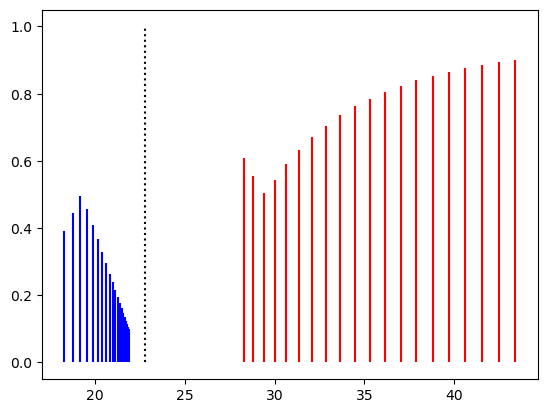

In [161]:
def get_polariton_omega(omega_0, omega_c, Omega):
    up = 0.5 * (omega_0**2 + Omega**2 + omega_c**2 \
                + np.sqrt((omega_0**2 + Omega**2 + omega_c**2)**2 - 4*omega_0**2*omega_c**2))
    lp = 0.5 * (omega_0**2 + Omega**2 + omega_c**2 \
                - np.sqrt((omega_0**2 + Omega**2 + omega_c**2)**2 - 4*omega_0**2*omega_c**2))
    return np.sqrt(up), np.sqrt(lp)

def get_polariton_intensity(omega_0, omega_c, Omega):
    theta = np.arctan(2 * omega_c * Omega / (omega_0**2 + Omega**2 - omega_c**2))
    return np.cos(theta / 2) ** 2, np.sin(theta / 2) ** 2

fig,ax = plt.subplots()
ax.vlines(vib_freq, 0,1,color = 'black', linestyle = 'dotted')
clist = ['r','g','black','blue','orange']

X = np.linspace(0, 70, 1000)
intensity = np.zeros(X.shape)

for i in np.arange(-0,20,1):
    o_up, o_lp = get_polariton_omega(vib_freq, vib_freq + i , 1e1)
    i_up, i_lp = get_polariton_intensity(vib_freq, vib_freq + i , 1e1)

    #intensity += i_up * np.exp(-(X - o_up)**2 / 2 * (5)**2) 
    #intensity += i_lp * np.exp(-(X - o_lp)**2 / 2 * (5)**2) 
    ax.vlines(o_up, 0, i_up, color= 'r')
    ax.vlines(o_lp, 0, i_lp, color = 'b')

fig.savefig('figure/foo.jpeg',dpi = 600)

In [146]:
#
# Define paths to pickle files and functions
#

def assert_path(path):
    try: 
        assert os.path.isdir(path)
    except AssertionError:
        raise Exception("Path {} is not exist".format(path))

def field_spectra(result_dict, limit = None):
    rad_profile = []
    
    for i, rd in result_dict.items():

        if limit and i > limit : 
            continue
        
        Afield = rd["field"]
        
        rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
        omega = red.convert_wavenumber(Afield.k_val)
        omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)
        
        foo = np.argsort(omega_profile)
        omega_profile = np.array(omega_profile)[foo]
        final_rad_profile = np.array(final_rad_profile)[foo]
        
        rad_profile.append(final_rad_profile)
        
    rad_profile = np.mean(rad_profile, axis = 0)
    
    return omega_profile, np.array(rad_profile)

def dipole_spectra(result_dict, h, time_frame = None, windows = 'Gaussian'):
    #h = result_dict['h']

    if time_frame: 
        ti, tf = time_frame
    
    dp_vel = np.array(result_dict['atoms'].observable['dipole_velocity'])
    #dp_vel = np.sum(
    #    result_dict['atoms'].observable['dipole'], axis = 1
    #)

    if time_frame: 
        time = np.array(result_dict['atoms'].observable['t'])
        time -= time[0]
        dp_vel = dp_vel[(time > ti) * (time < tf)]

    autocorr = calc_ACF(dp_vel)
    #autocorr = scipy.signal.correlate(dp_vel, dp_vel)
    yfft = calc_FFT(autocorr, windows)
    yfft = np.vstack([yfft[:,0],yfft[:,1], yfft[:,2]])
    yfft = np.sum(yfft, axis=0)
    ir = yfft[0:int(len(yfft)/2)]
    print(yfft.shape)
    
    delta_t = red.convert_time(h) * 1e-12 * 3e10
    wavenumber = np.fft.fftfreq(len(yfft), delta_t)[0:int(len(yfft)/2)]

    return np.array(wavenumber), np.array(ir)

In [157]:
single_path = 'pickle_jar//single'
assert_path(single_path)

with open(single_path + '/log.pkl', 'rb') as handle:
    result_dict = pickle.load(handle)

In [158]:
result_dict['atoms'].observable['dipole_velocity']

[array([4.72495877e-09, 4.95871498e-08, 4.95871498e-08]),
 array([4.72888565e-09, 4.96238417e-08, 4.96238417e-08]),
 array([4.76835658e-09, 4.99924686e-08, 4.99924686e-08]),
 array([4.80819787e-09, 5.03642219e-08, 5.03642219e-08]),
 array([4.84841339e-09, 5.07391316e-08, 5.07391316e-08]),
 array([4.88900707e-09, 5.11172280e-08, 5.11172280e-08]),
 array([4.92998287e-09, 5.14985419e-08, 5.14985419e-08]),
 array([4.97134482e-09, 5.18831041e-08, 5.18831041e-08]),
 array([5.01309697e-09, 5.22709462e-08, 5.22709462e-08]),
 array([5.05524345e-09, 5.26620996e-08, 5.26620996e-08]),
 array([5.09778839e-09, 5.30565966e-08, 5.30565966e-08]),
 array([5.14073603e-09, 5.34544693e-08, 5.34544693e-08]),
 array([5.18409060e-09, 5.38557507e-08, 5.38557507e-08]),
 array([5.22785642e-09, 5.42604736e-08, 5.42604736e-08]),
 array([5.27203785e-09, 5.46686717e-08, 5.46686717e-08]),
 array([5.31663929e-09, 5.50803786e-08, 5.50803786e-08]),
 array([5.36166521e-09, 5.54956286e-08, 5.54956286e-08]),
 array([5.4071

(8192,)


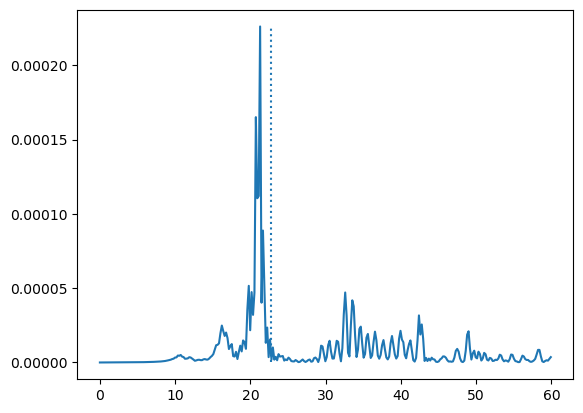

In [159]:
wn, ir = dipole_spectra(result_dict, h = 1e-2, time_frame = (50,500))
ir = ir[wn < 60]
wn = wn[wn < 60]

fig,ax = plt.subplots()
ax.plot(wn, ir)
ax.vlines(vib_freq, min(ir), max(ir), linestyle = 'dotted')

fig.savefig('figure/single.jpeg',dpi=600)

In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = i , N_pairs = N_pairs, save_path = 'figure2/longest_anime')